In [ ]:
import ee

try:
    ee.Initialize()
except:
    ee.Authenticate()
    ee.Initialize()

import geemap

*** Earth Engine *** Share your feedback by taking our Annual Developer Satisfaction Survey: https://google.qualtrics.com/jfe/form/SV_doiqkQG3NJ1t8IS?source=API


In [37]:
SPLIT = 0.5
dwl = ee.ImageCollection("projects/ee-geethensingh/assets/UQ/dwTest_probs_4326");

Features = ee.FeatureCollection(dwl.map(lambda img: ee.Feature(img.geometry()).centroid())).randomColumn(**{'seed': 42})
Features

dwCal = Features.filter(ee.Filter.lte('random', SPLIT))#Used to calibrate conformal classifer
dwTest = Features.filter(ee.Filter.gt('random', SPLIT))#Used to evaluate conformal classifier

In [3]:
Map = geemap.Map()
Map.addLayer(ee.Feature(Features.first()))
Map.centerObject(Features.first(), 13)
Map

Map(center=[51.404264731035134, -0.5168443261122375], controls=(WidgetControl(options=['position', 'transparen…

In [54]:
dwCal_gdf = ee.data.computeFeatures({
    'expression': dwCal,
    'fileFormat': 'GEOPANDAS_GEODATAFRAME'
})
dwTest_gdf = ee.data.computeFeatures({
    'expression': dwTest,
    'fileFormat': 'GEOPANDAS_GEODATAFRAME'
})

# Need to set the CRS.
# Make sure it matches the CRS of FeatureCollection geometries.
dwCal_gdf.crs = 'EPSG:4326'
dwTest_gdf.crs = 'EPSG:4326'
dwCal_gdf['Cal'] = 'Calibration'
dwTest_gdf['Cal'] = 'Test'

import pandas as pd
gdf = pd.concat([dwTest_gdf, dwCal_gdf], ignore_index=True)

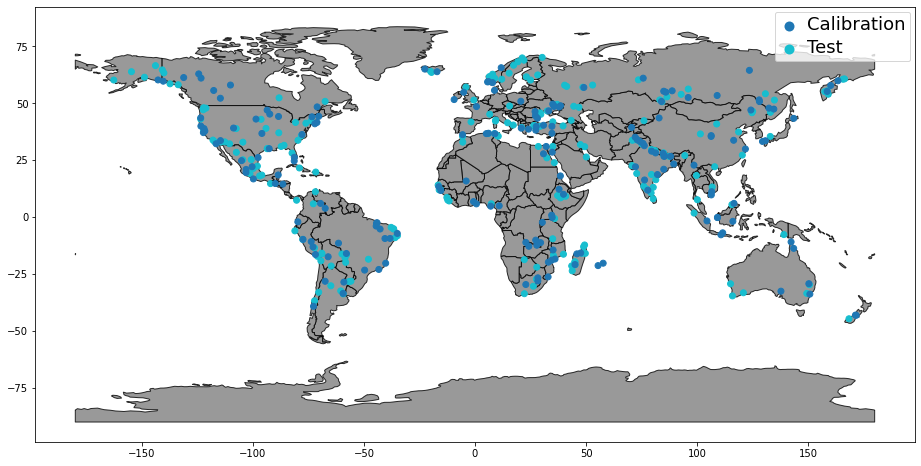

In [62]:
import geopandas as gpd
from matplotlib.ticker import FuncFormatter

# Create a base map
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
ax = world.plot(figsize=(20, 8), alpha=0.8, color='grey', edgecolor='k')

# Assuming you have defined dwCal_gdf and dwTest_gdf GeoDataFrames
gdf.plot(column = 'Cal', ax =ax, legend =True)

# Customize the legend
legend = ax.get_legend()
legend.set_bbox_to_anchor((1, 1))  # Adjust the legend position
for label in legend.get_texts():
    label.set_fontsize(18)  # Set font size for legend labels

# Format the x and y axes with latitude and longitude
def format_lon(value, pos):
    direction = 'N' if value >= 0 else 'S'
    return f'{abs(value)}° {direction}'
def format_lat(value, pos):
    direction = 'E' if value >= 0 else 'W'
    return f'{abs(value)}° {direction}'

ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: format_lat(round(x, 3), _)))
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: format_lon(round(y, 3), _)))

# Display the map
# plt.show()

# Save the map to an image file (e.g., PNG)
plt.savefig(r'C:\Users\coach\myfiles\postdoc\Uncertainty\figures\DW_sampleDist.png', bbox_inches='tight', pad_inches=0.1, dpi=350, transparent=True)